# Programmentwurf - Maschinelles Lernen

Jupiter-Notebook für den Datensatz "Cycling Data - A" in Rahmen des Moduls "Computational Intelligence und Maschinelles Lernen" von Ruslan Adilgereev und Valentin Langenbacher

## Laden der Daten

In [41]:
# Import von Bibliotheken/Funktionen
import pandas as pd  # Datenverarbeitung
import matplotlib.pyplot as plt  # Visualisierung
import seaborn as sns  # Visualisierung
from sklearn.neural_network import MLPRegressor  #  Multilayer Perceptron
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # Skalierung
from sklearn.model_selection import train_test_split  # Aufteilung der Daten in Trainings- und Testdaten
import scipy.stats as stats  # Statistik
from sklearn.metrics import mean_squared_error, r2_score  # Bewertung der Lernergebnisse

In [42]:
# Import der Daten
trainingData = "bike_rides_001.csv"  # Pfad zur Datei
df = pd.read_csv(trainingData, sep=";")  # Laden der Daten

## Datenvorbereitung

In [43]:
## ToDo: Check for missing values, scale/norm data, change Datetype, OneHotEncoding, delete Last Row

## delete Last Row
df = df.drop(df.index[len(df)-1])

## select features at least 8 out of 16:
## km, maxHm, max_speed, minHm, speed, type, ride_type
df = df[['Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed', 'type', 'ride_type', 'endtime', 'starttime']]

# List of columns to be converted
# Convert 'StartTime' and 'EndTime' to datetime format
df['starttime'] = pd.to_datetime(df['starttime'], format='%H:%M:%S')
df['endtime'] = pd.to_datetime(df['endtime'], format='%H:%M:%S')
df['duration_min'] = (df['endtime'] - df['starttime']).dt.total_seconds() / 60.0  # Calculate duration in minutes
df = df.drop(['starttime', 'endtime'], axis=1)  # Drop the columns

columns_to_convert = ['Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed']
# Loop through the list and convert each column
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.').astype('float64')

# One Hot Encoding - type, ride_type to get numerical values
df = pd.get_dummies(df, columns=['type', 'ride_type'])

## Skalierung
nachfolgende Skalierung wird verwendet zur
- verbesserten Konvergenz (schnelleres/ stabileres Training des Modells)
- Ausgleichen der Einheiten (Die Merkmale liegen in unterschiedlichen Einheiten und Skalen vor. Die Skalierung hilft dabei, dass die Merkmale gleichgewichtiger in die Modellbildung einfließen)
- Vermeidung numerischer Instabilitäten (reduziert das Risiko von Exploding und Vanishing Gradients)

In [44]:
## Scaling Data

columns_features = ['Hm', 'km', 'maxHm', 'max_speed', 'minHm', 'speed', 'duration_min']
# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply Min-Max scaling (scaling to the range [0,1])

df_minmax = pd.DataFrame(min_max_scaler.fit_transform(df[columns_features]), columns=columns_features)

# Apply z-Norm scaling (scaling to a mean of 0 and a standard deviation of 1)

df_znorm = pd.DataFrame(standard_scaler.fit_transform(df[columns_features]), columns=columns_features)

Extrahieren der OneHot-kodierten Spalten zur Kategorisierung von
- Fahrradtypen (MTB, Trecking, Rennrad)
- Streckenarten (Pendeln, Rennen, Training)

In [45]:
# Extract only the one-hot encoded columns from df_onehot
df_onehot_only = df.drop(columns=columns_features)

# Concatenate the one-hot encoded columns with the Min-Max scaled DataFrame
df = pd.concat([df, df_onehot_only.reset_index(drop=True)], axis=1)

In [46]:

# Features and target variable for Min-Max scaled data
# Comment out the one you don't want to use
df = df_minmax
#df = df_znorm

X = df.drop('Hm', axis=1)
y = df['Hm']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
# Split data

## a) Multilayer Perceptron

In [47]:
# Initialize the MLP Regressor, epochs = 1000, learning rate = 0.001
mlp = MLPRegressor(hidden_layer_sizes=(500, 500, 500), max_iter=1000)

# Train the model using data
mlp.fit(X_train, y_train)  # Train the model

y_pred = mlp.predict(X_val)  # Make predictions on validation set
mse = mean_squared_error(y_val, y_pred)  # Evaluate the model
mse_score = mlp.score(X_val, y_val)  # Evaluate the model
r2 = r2_score(y_val, y_pred)  # Evaluate the model
print(f'Mean Squared Error: {mse}')
print(f'MLP Score: {mse_score}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.0005318021332858466
MLP Score: 0.9407063608760174
R2 Score: 0.9407063608760174


### Bewertung der Lernergebnisse MLP

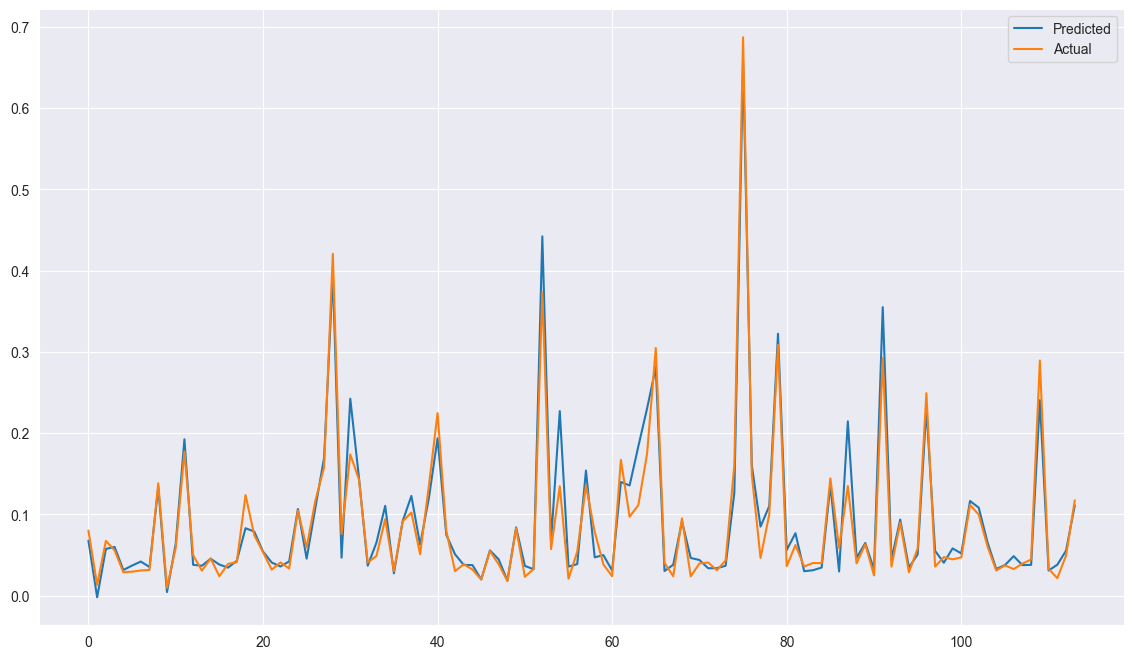

In [48]:
# Plot the y_pred_znorm and y_val_znorm
plt.figure(figsize=(14, 8))
plt.plot(y_pred, label='Predicted')
plt.plot(y_val.values, label='Actual')
plt.legend()
plt.show()

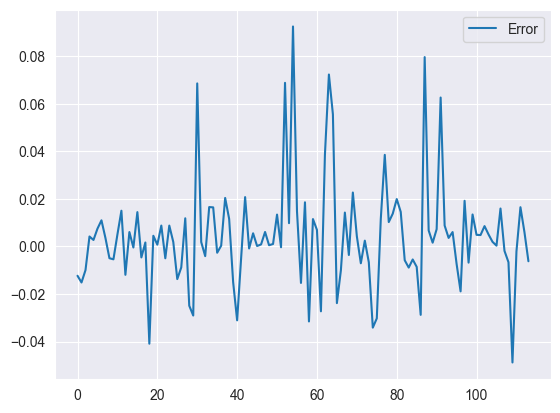

In [49]:
# Plot the y_pred_znorm and y_val_znorm
plt.plot(y_pred - y_val.values, label='Error')
plt.legend()
plt.show()

Hm              1.000000
km              0.885016
duration_min    0.867896
max_speed       0.598599
maxHm           0.597764
speed           0.289848
minHm           0.228424
Name: Hm, dtype: float64


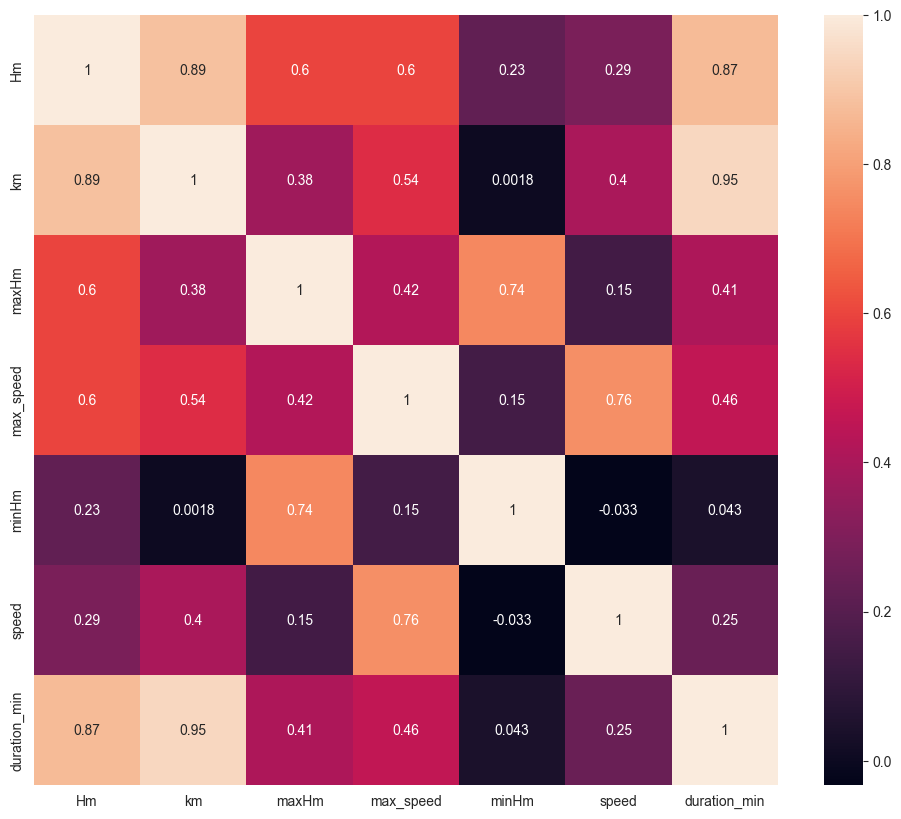

In [50]:
# Calculate correlation matrix
corr = df.corr()

# Print correlation values
print(df.corr()['Hm'].sort_values(ascending=False))

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()


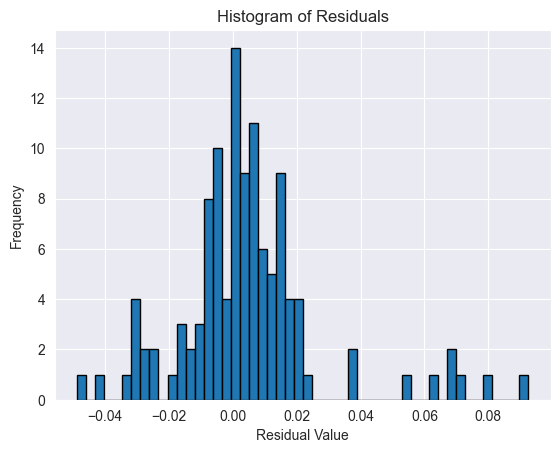

In [51]:
# Calculate residuals
residuals = y_pred - y_val.values

# Create histogram
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.show()


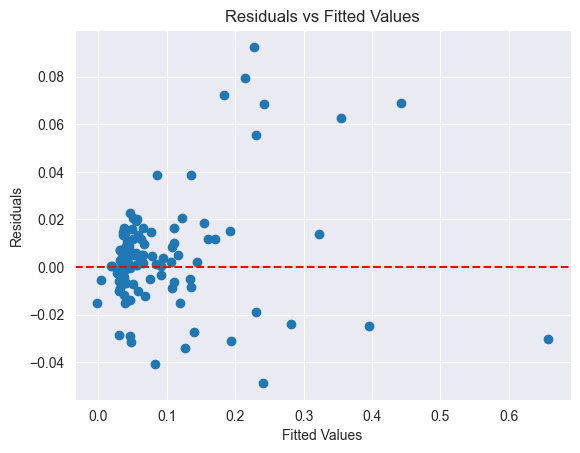

In [52]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

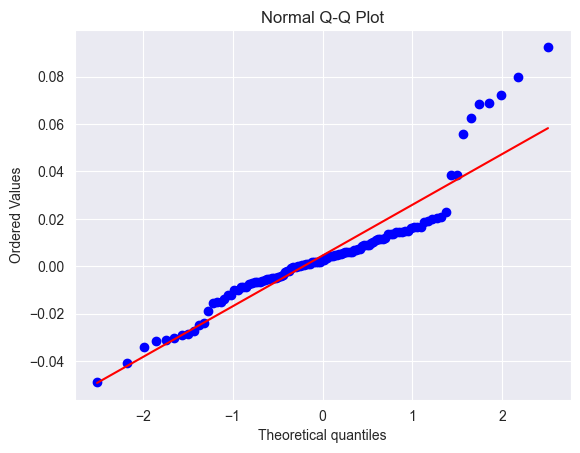

In [53]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")
plt.show()

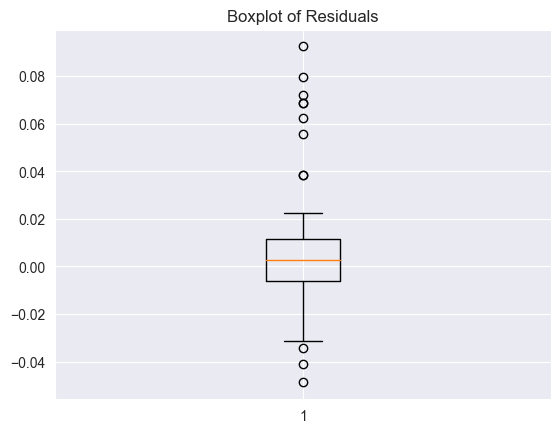

In [54]:
plt.boxplot(residuals)
plt.title('Boxplot of Residuals')
plt.show()

Train MSE: 0.0005382644745358079
Train R2 Score: 0.9595195921153487


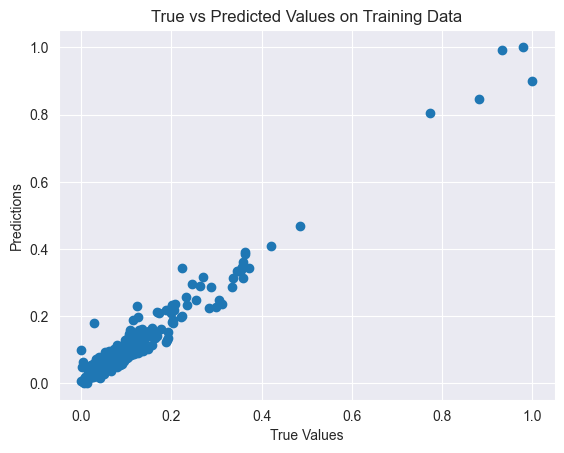

In [55]:
y_pred_train = mlp.predict(X_train)


mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print(f"Train MSE: {mse_train}")
print(f"Train R2 Score: {r2_train}")

plt.scatter(y_train, y_pred_train)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values on Training Data')
plt.show()

## b) Verfahren zur Linearen Regression

In [56]:
# Linear Regression
from sklearn.linear_model import LinearRegression
LinearRegression = LinearRegression()
LinearRegression.fit(X_train, y_train)
y_pred = LinearRegression.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

Mean Squared Error: 0.0012211455109119578
R2 Score: 0.8638475539868393


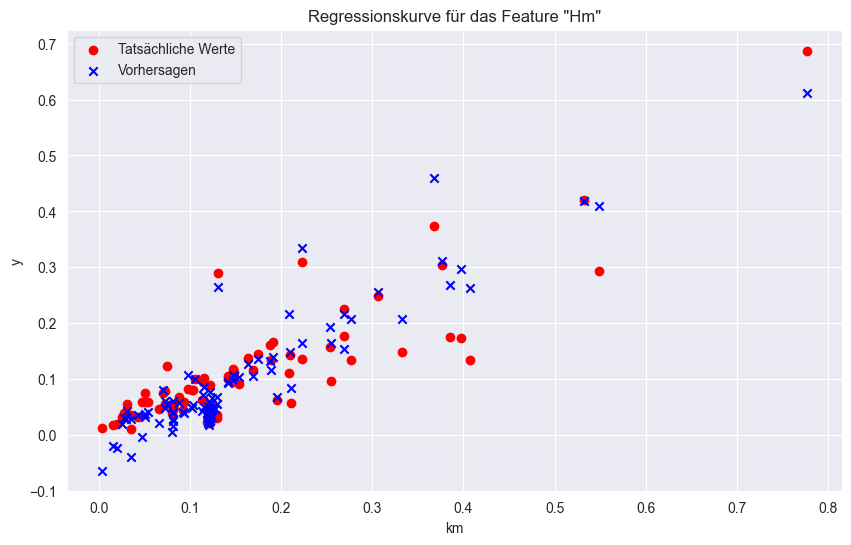

In [57]:
# Darstellung der Regressionskurve und der tatsächlichen Datenpunkte für das Feature "km"
plt.figure(figsize=(10, 6))
plt.scatter(X_val["km"], y_val, color='red', label='Tatsächliche Werte')
plt.scatter(X_val["km"], y_pred, color='blue', marker='x', label='Vorhersagen')
plt.title('Regressionskurve für das Feature "Hm"')
plt.xlabel('km')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


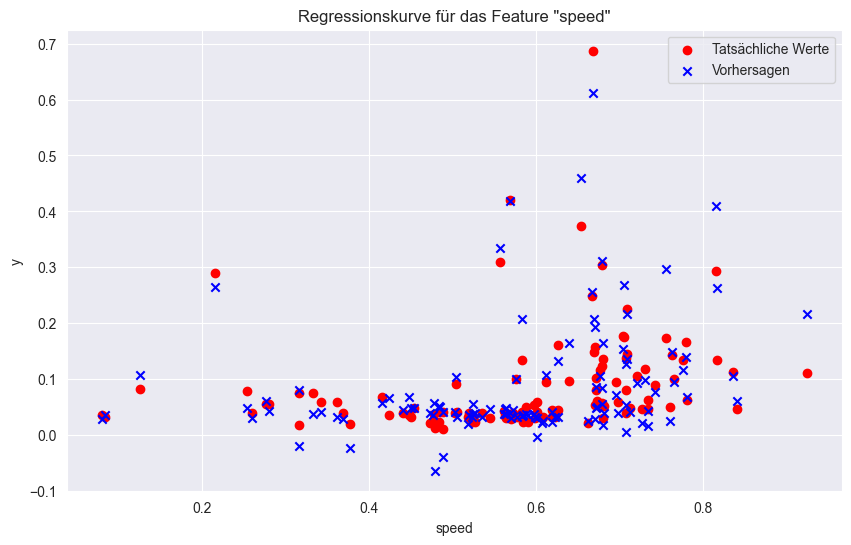

In [58]:
# Darstellung der Regressionskurve und der tatsächlichen Datenpunkte für das Feature "speed"
plt.figure(figsize=(10, 6))
plt.scatter(X_val["speed"], y_val, color='red', label='Tatsächliche Werte')
plt.scatter(X_val["speed"], y_pred, color='blue', marker='x', label='Vorhersagen')
plt.title('Regressionskurve für das Feature "speed"')
plt.xlabel('speed')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

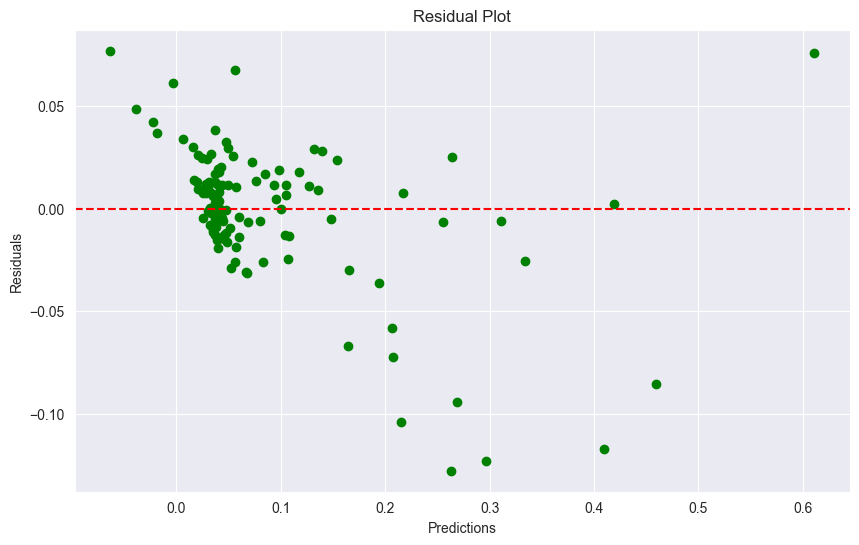

In [59]:
# Residualplot
residuals = y_val - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

## Vergleich
- tbd: vergleich beider Verfahren
- tbd: Qualitätskriterien? Interpretation?